# Results

1. Train the model using `train.py`. For example for LeNet Dropout model: 
    
    `python train.py --epochs 50 --bs 16 --log_dir res/mnist/lenet5/do-mybn/ --model LeNet --dropout 0.5 --data mnist --decrease_from 1`
    
    Note that for Deep Ensembles you need to train 6 models:
    
    `python train.py --seed 0 --epochs 50 --bs 16 --log_dir res/mnist/lenet5/de/0 --model LeNet --data mnist --decrease_from 1 &`
    
    `python train.py --seed 1 --epochs 50 --bs 16 --log_dir res/mnist/lenet5/de/1 --model LeNet --data mnist --decrease_from 1 &`
    
    etc ...

2. Use `infer_proba_bn.py` and `infer_proba_de.py` to gather predictions:

    `python infer_proba_de.py --models_dir res/mnist/lenet5/de/ --n_models 6 --data_kn mnist --data_ukn not-mnist --n_classes 10`
    
    `python infer_proba_bn.py --model res/mnist/lenet5/do-mybn/model --data_kn mnist --data_ukn not-mnist --n_classes 10`
    
    The logs files will be placed into model directories.

In [2]:
import torch
import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [102]:
# insert here your paths
de_res = torch.load('res/mnist/lenet5/de/de_eval_data')
do_res = torch.load('res/mnist/lenet5/do-mybn/eval_data')

## Accuracy and NLL on test set

In [89]:
from sklearn.metrics import log_loss, accuracy_score
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, -1)[..., np.newaxis])
    return e_x / e_x.sum(axis=-1)[..., np.newaxis]

In [104]:
de_labels = de_res['known']['labels']
de_proba_ens = softmax(de_res['known']['ensemble/logits'])
de_proba_eval = softmax(de_res['known']['eval/logits'])

do_labels = do_res['known']['ensemble/labels']
do_proba_ens = softmax(do_res['known']['ensemble/logits'])
do_proba_eval = softmax(do_res['known']['eval/logits'])

In [108]:
p = de_proba_ens[0].mean(0)
print('SBN -- acc {:.3f} , NLL {:.4f}'.format(accuracy_score(labels, p.argmax(1)), log_loss(labels, p)))
p = de_proba_eval.mean(0)
print('DE -- acc {:.3f} , NLL {:.4f}'.format(accuracy_score(labels, p.argmax(1)), log_loss(labels, p)))
p = do_proba_eval.mean(0)
print('DO -- acc {:.3f} , NLL {:.4f}'.format(accuracy_score(labels, p.argmax(1)), log_loss(labels, p)))

p = de_proba_ens.mean((0, 1))
print('DE + SBN -- acc {:.3f} , NLL {:.4f}'.format(accuracy_score(labels, p.argmax(1)), log_loss(labels, p)))
p = do_proba_ens.mean(0)
print('DO + SBN -- acc {:.3f} , NLL {:.4f}'.format(accuracy_score(labels, p.argmax(1)), log_loss(labels, p)))

SBN -- acc 0.994 , NLL 0.0286
DE -- acc 0.996 , NLL 0.0157
DO -- acc 0.996 , NLL 0.0142
DE + SBN -- acc 0.996 , NLL 0.0150
DO + SBN -- acc 0.996 , NLL 0.0145


## Entropy CDF plots

In [113]:
de_proba_ens = softmax(de_res['unknown']['ensemble/logits'])
de_proba_eval = softmax(de_res['unknown']['eval/logits'])

do_proba_ens = softmax(do_res['unknown']['ensemble/logits'])
do_proba_eval = softmax(do_res['unknown']['eval/logits'])

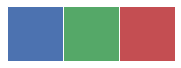

In [118]:
colors = sns.color_palette(n_colors=3)
sns.palplot(colors)

Text(0,0.5,u'CDF')

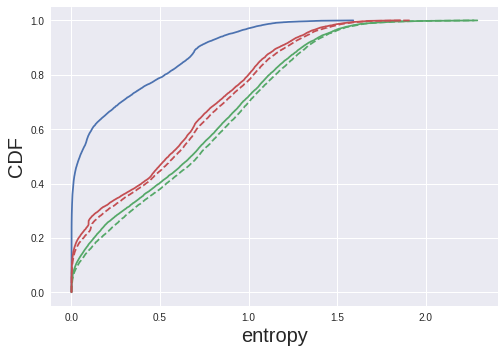

In [126]:
p = de_proba_ens[0].mean(0)
plt.plot(*utils.entropy_plot_xy(p), c=colors[0], label='SBN')

p = do_proba_eval.mean(0)
plt.plot(*utils.entropy_plot_xy(p), c=colors[1], label='DO')

p = do_proba_ens.mean(0)
plt.plot(*utils.entropy_plot_xy(p), c=colors[1], ls='--', label='DO + SBN')

p = de_proba_eval.mean(0)
plt.plot(*utils.entropy_plot_xy(p), c=colors[2], label='DE')

p = de_proba_ens.mean((0, 1))
plt.plot(*utils.entropy_plot_xy(p), c=colors[2], ls='--', label='DE + SBN')

plt.xlabel('entropy', size=20)
plt.ylabel('CDF', size=20)